File found at ../model/xgb_models/xgb_model_7.json


<Figure size 1000x800 with 0 Axes>

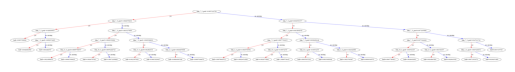

In [35]:
import os
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import graphviz

target_T = 7

# 指定Graphviz的路径
os.environ["PATH"] += os.pathsep + 'E:\\Graphviz\\bin'

model_path = f'../model/xgb_models/xgb_model_{target_T}.json'
if not os.path.isfile(model_path):
    print(f"No file found at {model_path}")
else:
    print(f"File found at {model_path}")
    # 加载模型
    bst = xgb.Booster()
    bst.load_model(model_path)
    # 绘制决策树
    plt.figure(figsize=(10, 8))  # 可以调整图形大小
    xgb.plot_tree(bst, num_trees=0)
    
    # 保存图像
    plt.savefig(f'xgb_tree_{target_T}.png', dpi=300, bbox_inches='tight')
    plt.show()  # 然后显示图形
    plt.close()  # 关闭图形，释放内存
    
    # 使用to_graphviz生成竖直布局的Graphviz数据
    dot = xgb.to_graphviz(bst, num_trees=0, rankdir='TB')
    
    # 保存到.dot文件
    dot_file = 'vertical_tree.dot'
    dot.render(dot_file, format='dot')

In [39]:
from xgboost import plot_importance

# 特征重要性分析
plot_importance(bst,importance_type='gain')
# 保存高清图片
# plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


ValueError: Image size of 1033001x449 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [40]:
fig, ax = plt.subplots(figsize=(10, 20))  # 可以调整这里的尺寸参数
plot_importance(bst, importance_type='gain', ax=ax)
plt.show()

ValueError: Image size of 1613888x1619 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x2000 with 1 Axes>

In [41]:
# import xgboost as xgb
from pyecharts.charts import Bar
from pyecharts import options as opts

# 假设 bst 是你的 XGBoost 模型
f_scores = bst.get_score(importance_type='weight')  # 提取特征重要性，这里使用 'weight'

# 准备数据
features = list(f_scores.keys())
importances = list(f_scores.values())

# 使用 Pyecharts 的 Bar 创建条形图
bar = Bar()
bar.add_xaxis(features)
bar.add_yaxis("Feature Importance", importances)
bar.set_global_opts(title_opts=opts.TitleOpts(title="XGBoost Feature Importance"),
                    xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-90)))  # 如果特征名称太长，可以将标签旋转以便阅读

# 渲染图表到 HTML 文件，可以在浏览器中查看
bar.render('feature_importance.html')

print('features:', features)
print('importances:', importances)

features: ['lstm_1_Y_pred', 'lstm_3_Y_pred', 'lstm_7_Y_pred', 'lstm_15_Y_pred', 'lstm_30_Y_pred']
importances: [231.0, 237.0, 218.0, 186.0, 166.0]


In [30]:
# XGB模型结果 to latex

import xgboost as xgb
bst = xgb.Booster()
bst.load_model(model_path)
# 假设你的模型名为bst
# 选择要导出的树的编号，例如0
tree = bst.get_dump(dump_format='json')[0]  # 使用JSON格式

import json

tree_structure = json.loads(tree)

def generate_tikz(node, depth=0):
    indent = "  " * depth
    if 'leaf' in node:
        # 叶子节点，直接返回结果
        return f"{indent}node {{$\\text{{叶节点: {node['leaf']}}}$}}"
    else:
        # 处理非叶子节点，需要显示条件
        condition = node['split'].replace('_', '\\_') + ' < ' + str(node['split_condition'])
        left_child = generate_tikz(node['children'][0], depth + 1)
        right_child = generate_tikz(node['children'][1], depth + 1)
        return f"{indent}node {{$\\text{{{condition}}}$}}\n{indent}child {{\n{left_child}\n{indent}}}\n{indent}child {{\n{right_child}\n{indent}}}"

tikz_tree = generate_tikz(tree_structure)
print("\\begin{tikzpicture}")
print(tikz_tree)
print("\\end{tikzpicture}")


\begin{tikzpicture}
node {$\text{model\_7\_Y\_pred < -0.00072132796}$}
child {
  node {$\text{model\_7\_Y\_pred < -0.00683796033}$}
  child {
    node {$\text{model\_7\_Y\_pred < -0.0160149857}$}
    child {
      node {$\text{叶节点: -0.00655296026}$}
    }
    child {
      node {$\text{model\_7\_Y\_pred < -0.00910734385}$}
      child {
        node {$\text{叶节点: -0.00414063968}$}
      }
      child {
        node {$\text{叶节点: -0.0031466505}$}
      }
    }
  }
  child {
    node {$\text{model\_7\_Y\_pred < -0.00351570919}$}
    child {
      node {$\text{model\_7\_Y\_pred < -0.00411598384}$}
      child {
        node {$\text{model\_15\_Y\_pred < 0.000997988507}$}
        child {
          node {$\text{叶节点: -0.00214806874}$}
        }
        child {
          node {$\text{叶节点: -0.000417096628}$}
        }
      }
      child {
        node {$\text{model\_30\_Y\_pred < 0.000592828728}$}
        child {
          node {$\text{叶节点: -0.00166787661}$}
        }
        child {
          n

In [26]:
import pygraphviz as pgv

# 加载完整的Graphviz图
G = pgv.AGraph('vertical_tree.dot')

# 辅助函数，递归获取所有子节点
def get_all_subtree_nodes(graph, start_node):
    subtree_nodes = set()
    nodes_to_visit = [start_node]
    while nodes_to_visit:
        current_node = nodes_to_visit.pop()
        if current_node not in subtree_nodes:
            subtree_nodes.add(current_node)
            nodes_to_visit.extend(graph.successors(current_node))
    return list(subtree_nodes)

# 假设节点0是根节点，节点1和节点2是第一层的两个分支节点
# 子图1包含节点0和以节点1为根节点的所有子树
subtree_nodes_1 = get_all_subtree_nodes(G, "1")
subtree_nodes_1.append("0")  # 添加根节点到子图
subgraph1 = G.subgraph(subtree_nodes_1, name='cluster_s1')

# 子图2包含节点0和以节点2为根节点的所有子树
subtree_nodes_2 = get_all_subtree_nodes(G, "2")
subtree_nodes_2.append("0")  # 添加根节点到子图
subgraph2 = G.subgraph(subtree_nodes_2, name='cluster_s2')

# 保存两个子图
subgraph1.write('subgraph1.dot')
subgraph2.write('subgraph2.dot')

# 可以进一步转换为PDF
subgraph1.layout(prog='dot')
subgraph1.draw('subgraph1.pdf', format='pdf')
subgraph2.layout(prog='dot')
subgraph2.draw('subgraph2.pdf', format='pdf')
